# Extended DMD for Van Der Pol System

In this example, we will train a linear Koopman model using EDMD (see Williams,
Kevrekidis & Rowley, _"A Data–Driven Approximation of the Koopman Operator: Extending
 Dynamic Mode Decomposition"_, Journal of Nonlinear Science 25, pp. 1307-1346, 2015)
for a nonlinear, dynamical system. The approach is demonstrated for discrete-time Van
 der Pol system in reverse time:

$$x_{k+1} = x_k - y_k dt,\\
y_{k+1} = y_k + (x_k-y_k+x_k^2y_k)dt$$

where $dt=0.1$ (this is example II from Surana & Banaszuk, _"Linear observer synthesis
for nonlinear systems using Koopman Operator framework"_, IFAC 49-18 (2016), pp.
716-723).

In [1]:
import sys
sys.path.append('../src')

In [2]:
import pykoopman as pk
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

from pykoopman.common import rev_dvdp  # discrete-time, reverse-time van der Pol

### Collect training data
The training data consists of a snapshot pair taken from 51 uniformly distributed
random initial conditions.

In [3]:
n_states = 2  # Number of states
dT = 0.1      # Timestep
n_traj = 51   # Number of trajectories
n_int = 4     # Integration length

# Uniform distribution of initial conditions
x = xE = 2*rnd.random([n_states, n_traj])-1

# Init
X = np.zeros((n_states, n_int*n_traj))
Y = np.zeros((n_states, n_int*n_traj))

# Integrate
for step in range(n_int):
    y = rev_dvdp(0, x, 0, dT)
    X[:, (step)*n_traj:(step+1)*n_traj] = x
    Y[:, (step)*n_traj:(step+1)*n_traj] = y
    x = y

Text(0.5, 1.0, 'training data. num traj = 51, each traj time step = 4')

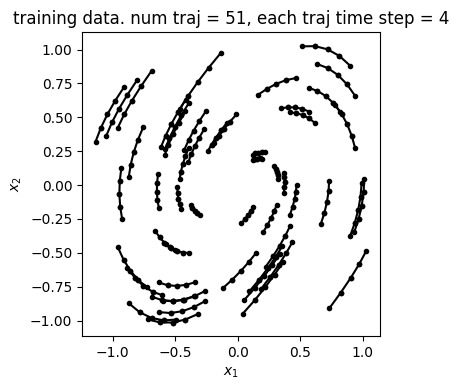

In [4]:
# Visualize first 100 steps of the training data
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(4, 4))
for traj_idx in range(n_traj):
    axs.plot([X[0, traj_idx::n_traj], Y[0, traj_idx::n_traj]],
             [X[1, traj_idx::n_traj], Y[1, traj_idx::n_traj]], '-ok',markersize=3)
axs.set(ylabel=r'$x_2$', xlabel=r'$x_1$')
axs.set_title('training data. num traj = {}, each traj time step = {}'.format(n_traj,n_int))

### Koopman regression using EDMD
As basis functions we choose thinplate radial basis functions.

In [5]:
EDMD = pk.regression.EDMD()
centers = np.random.uniform(-1,1,(2,10))
RBF = pk.observables.RadialBasisFunction(
    rbf_type="thinplate",
    n_centers=centers.shape[1],
    centers=centers,
    kernel_width=1,
    polyharmonic_coeff=1.0,
    include_state=True,
)

model = pk.Koopman(observables=RBF, regressor=EDMD)
model.fit(X.T, y=Y.T)

Koopman(observables=RadialBasisFunction(centers=array([[-0.37128804,  0.01714138,  0.81513295, -0.50141554, -0.17923415,
         0.51110228, -0.54240367, -0.84604018, -0.42049709, -0.67755743],
       [ 0.8593953 ,  0.61624076,  0.26680751,  0.74292118,  0.60734415,
        -0.62685988,  0.785118  ,  0.07868448,  0.61488031,  0.7921826 ]]),
                                        kernel_width=1, rbf_type='thinplate'),
        regressor=EDMD())

### Prediction
First, we will use the fitted EDMD model to predict the evolution for a single
initial condition. The inverse transformation, i.e. from observables back to the
state, is estimated using least-squares regression within the Koopman regressor.
Afterwards, we will show the prediction performance for the training data.

In [6]:
# x0 = [0.6, -0.6]
x0 = np.array([0.15, -1.3])
T = 10
t = np.arange(0, T, dT)

# Integrate
Xtrue = np.zeros((len(t), n_states))
Xtrue[0, :] = x0
for step in range(len(t)-1):
    y = rev_dvdp(0, Xtrue[step, :][:, np.newaxis], 0, dT)
    Xtrue[step+1, :] = y.ravel()

# Simulate (multi-step prediction) Koopman model
Xkoop = model.simulate(x0, n_steps=len(t)-1)
Xkoop = np.vstack([x0[np.newaxis,:], Xkoop])

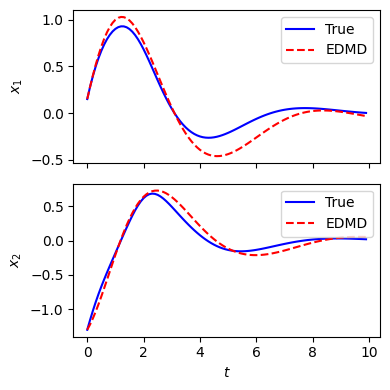

In [7]:
fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True, figsize=(4, 4))
axs[0].plot(t, Xtrue[:, 0], '-', color='b', label='True')
axs[0].plot(t, Xkoop[:, 0], '--r', label='EDMD')
axs[0].set(ylabel=r'$x_1$')
axs[1].plot(t, Xtrue[:, 1], '-', color='b', label='True')
axs[1].plot(t, Xkoop[:, 1], '--r', label='EDMD')
axs[1].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')
for i in range(2):
    axs[i].legend(loc='best')

In [8]:
# Init
Xk = np.zeros((n_states, n_int*n_traj))
Yk = np.zeros((n_states, n_int*n_traj))

# 1-step prediction using Koopman model
x = xE.T
for k in range(n_int):
    # print(k)
    yT = model.predict(x)
    y = yT.T
    Xk[:, k*n_traj:(k+1)*n_traj] = x.T
    Yk[:, k*n_traj:(k+1)*n_traj] = y
    x = y.T

## Visualize

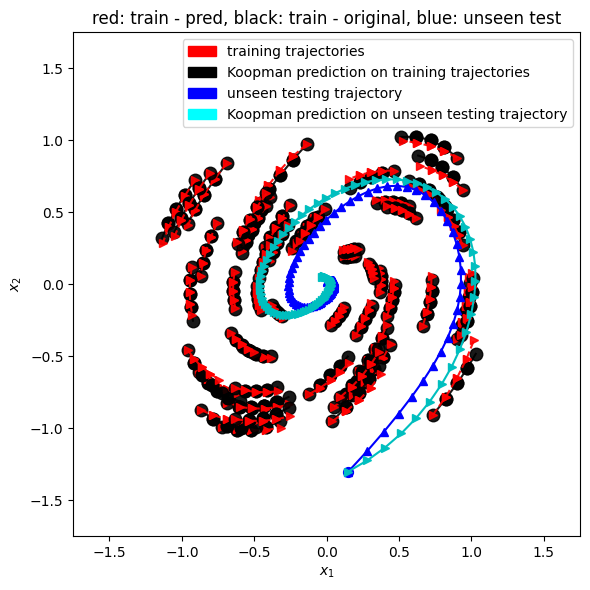

In [9]:

fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
legend_list = ['training - true', 'training - pred']
for traj_idx in range(n_traj):
    # label = legend_list[0] if traj_idx == 0 else None
    axs.plot([X[0, traj_idx::n_traj], Y[0, traj_idx::n_traj]],
             [X[1, traj_idx::n_traj], Y[1, traj_idx::n_traj]],'-ok',alpha=0.9,markersize=9)
    # label = legend_list[1] if traj_idx == 0 else None
    axs.plot([Xk[0, traj_idx::n_traj], Yk[0, traj_idx::n_traj]],
             [Xk[1, traj_idx::n_traj], Yk[1, traj_idx::n_traj]], '-->r',alpha=0.9)
axs.set(ylabel=r'$x_2$',
        xlabel=r'$x_1$')

axs.plot(Xtrue[:,0], Xtrue[:,1],'-^b')
axs.plot(Xkoop[:,0], Xkoop[:,1],'->c')

axs.scatter(x0[0],x0[1],s=50,c='b',label='unseen test')
axs.set_title('red: train - pred, black: train - original, blue: unseen test')

red_patch = mpatches.Patch(color='red', label='training trajectories')
black_patch = mpatches.Patch(color='black', label='Koopman prediction on training trajectories')
blue_patch = mpatches.Patch(color='blue', label='unseen testing trajectory')
cyan_patch = mpatches.Patch(color='cyan', label='Koopman prediction on unseen testing trajectory')

axs.set_xlim([-1.75,1.75])
axs.set_ylim([-1.75,1.75])

axs.legend(handles=[red_patch, black_patch, blue_patch, cyan_patch],loc='best', )
